Лабораторная работа №4 “Нейронные сети”
=====
Лабораточная работа выполнена на языке **Python** c помощью интерактивной оболочки **Jupyter Notebook**
Исходный код работы - lab4.py.
Файл jupyter notebook - lab4.ipynb

Набор данных ex4data1.mat (такой же, как в лабораторной работе №2) представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит 5000 изображений 20x20 в оттенках серого. Каждый пиксель представляет собой значение яркости (вещественное число). Каждое изображение сохранено в виде вектора из 400 элементов. В результате загрузки набора данных должна быть получена матрица 5000x400. Далее расположены метки классов изображений от 1 до 9 (соответствуют цифрам от 1 до 9), а также 10 (соответствует цифре 0).
## Ход работы

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.io
import matplotlib.image as mpimg

### Загрузите данные ex4data1.mat из файла.

In [42]:
data = scipy.io.loadmat('ex4data1.mat')
x = np.array(data['X'])
y = np.squeeze(data['y'])
np.place(y, y == 10, 0)
n = x.shape[1]
m = x.shape[0]
num_labels = 10
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units

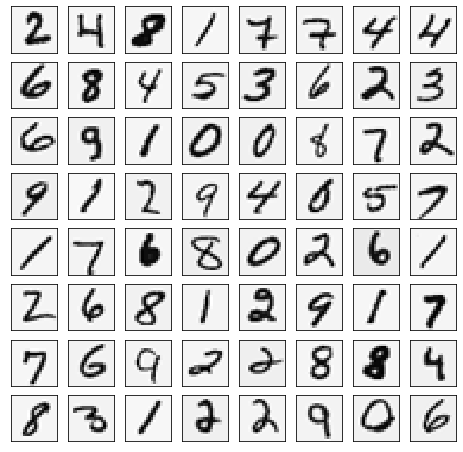

In [3]:
subplots = 64
draw_seed = np.random.randint(low=0, high=x.shape[0], size=subplots)
draw_rows = x[draw_seed]
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    data = np.reshape(draw_rows[i], (20, 20), order='F')
    axi.imshow(data, cmap='binary')
    axi.set(xticks=[], yticks=[])

plt.show()

### Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26). Какова структура полученной нейронной сети?

In [16]:
weights = scipy.io.loadmat('ex4weights.mat')
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
theta1, theta2 = weights['Theta1'], weights['Theta2']
# swap first and last columns of Theta2, due to legacy from MATLAB indexing,
# since the weight file ex3weights.mat was saved based on MATLAB indexing
theta2 = np.roll(theta2, 1, axis=0)

Данная нейроная сеть содержит 3 слоя: входной слой из 400 узлов, сткрытый слой из 25 узлов и выходной слой на 10 узлов.

### Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации. 

In [5]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))


def predict(X, theta1, theta2):
    m = X.shape[0]
    X = np.hstack((np.ones((m, 1)), X))
    a1 = sigmoid(X.dot(theta1.T))
    a1 = np.hstack((np.ones((m, 1)), a1))  # hidden layer
    a2 = sigmoid(a1.dot(theta2.T))  # output layer
    return np.argmax(a2, axis=1)

### Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [8]:
p = predict(x, theta1, theta2)
print(f'Prediction on training set: {np.mean(p == y) * 100}%')

Prediction on training set: 97.52%


Использую логистическую регрессию в лабораторной 2 была полученна точность 94.74%. Точность предсказаний данной нейронной сети на 2.8% лучше.

### Перекодируйте исходные метки классов по схеме one-hot.

In [26]:
y_matrix = np.eye(num_labels)[y]

### Реализуйте функцию стоимости для данной нейронной сети.

In [27]:
a1 = np.hstack([np.ones((m, 1)), x])

a2 = sigmoid(a1.dot(theta1.T))
a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])

a3 = sigmoid(a2.dot(theta2.T))

cost = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix))
print(f'Cost(not regularized): {cost}')

Cost(not regularized): 0.2876291651613189


### Добавьте L2-регуляризацию в функцию стоимости.

In [29]:
# Add regularization term
lambda_ = 1
reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])))
cost_reg = cost + reg_term
print(f'Cost(regularized): {cost_reg}')

Cost(regularized): 0.38376985909092365


### Реализуйте функцию вычисления производной для функции активации.

In [30]:
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid)

In [34]:
print(f'For large values gradient should be close to zero, sigmoidGradient(1000) = {sigmoidGradient(1000)}')

For large values gradient should be close to zero, sigmoidGradient(1000) = 0.0


In [38]:
print(f'Gradient should be exacly 0.25 for 0, sigmiodGradient(0) = {sigmoidGradient(0)}')

Gradient should be exacly 0.25 for 0, sigmiodGradient(0) = 0.25


### Инициализируйте веса небольшими случайными числами.

In [40]:
def rand_init_weights(l_in, l_out, epsilon=0.12):
    return np.random.rand(l_out, 1 + l_in) * 2 * epsilon - epsilon

In [43]:
initial_theta1 = rand_init_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_init_weights(hidden_layer_size, num_labels)

### Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.

In [50]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
     theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    m = y.size
    # Feedforward propagation
    a1 = np.hstack([np.ones((m, 1)), X])
    a2 = sigmoid(a1.dot(theta1.T))
    a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])
    a3 = sigmoid(a2.dot(theta2.T))
    # Cost calc
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])))
    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix)) + reg_term
    # Backpropogation
    delta_3 = a3 - y_matrix
    delta_2 = delta_3.dot(theta2)[:, 1:] * sigmoidGradient(a1.dot(theta1.T))
    delta1 = delta_2.T.dot(a1)
    delta2 = delta_3.T.dot(a2)
    # Add regularization to gradient
    theta1_grad = (1 / m) * delta1
    theta1_grad[:, 1:] = theta1_grad[:, 1:] + (lambda_ / m) * theta1[:, 1:]
    theta2_grad = (1 / m) * delta2
    theta2_grad[:, 1:] = theta2_grad[:, 1:] + (lambda_ / m) * theta2[:, 1:]
    grad = np.concatenate([theta1_grad.ravel(), theta2_grad.ravel()])
    return J, grad

### Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10-4.

In [72]:
def compute_numerical_gradient(J, theta, e=1e-4):
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        cost1, _ = J(theta - perturb[:, i])
        cost2, _ = J(theta + perturb[:, i])
        numgrad[i] = (cost2 - cost1) / (2 * e)
    return numgrad

In [82]:
def check_nn_gradients(nn_cost_function, lambda_=0.0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    # We generate some 'random' test data
    theta1 = rand_init_weights(hidden_layer_size-1, input_layer_size+1)
    theta2 = rand_init_weights(num_labels-1, hidden_layer_size+1)
    X = rand_init_weights(m-1, input_layer_size)
    X = X.reshape(m, num_labels)
    y = np.arange(1, 1+m) % num_labels
    # Unroll parameters
    nn_params = np.concatenate([theta1.ravel(), theta2.ravel()])
    # short hand for cost function
    cost_func = lambda p: nn_cost_function(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = cost_func(nn_params)
    numgrad = compute_numerical_gradient(cost_func, nn_params)
    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print('The two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)')
    print(np.stack([numgrad[:5], grad[:5]], axis=1))
    # Evaluate the norm of the difference between two the solutions. If you have a correct
    # implementation, and assuming you used e = 0.0001, then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)
    print('If backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n'
          f'Relative Difference: {diff}')

In [83]:
check_nn_gradients(nn_cost_function)

The two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)
[[ 2.65454490e-03  2.65454490e-03]
 [-8.69657746e-05 -8.69657754e-05]
 [ 4.72294761e-04  4.72294764e-04]
 [ 1.21512829e-04  1.21512831e-04]
 [-6.56266561e-04 -6.56266565e-04]]
If backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9). 
Relative Difference: 2.9930853667124326e-11


### Добавьте L2-регуляризацию в процесс вычисления градиентов. Проверьте полученные значения градиента.

In [84]:
check_nn_gradients(nn_cost_function, lambda_=1.0)

The two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)
[[-0.00015403 -0.00015403]
 [-0.00517767 -0.00517767]
 [-0.01576813 -0.01576813]
 [ 0.00205132  0.00205132]
 [-0.00560234 -0.00560234]]
If backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9). 
Relative Difference: 1.8415564955692822e-11


### Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.

In [57]:
def nn_gradient_descent(nn_params, cost_func, alpha, num_iters):
    j_history = []
    for i in range(0, num_iters):
        cost, grad = cost_func(nn_params)
        nn_params -= alpha * grad
        j_history.append(cost)

    return nn_params, j_history

In [58]:
initial_theta1 = rand_init_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_init_weights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate([initial_theta1.ravel(), initial_theta2.ravel()])
nn_params, costs = nn_gradient_descent(initial_nn_params,
                    cost_func=lambda p: nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, x, y, lambda_=1),
                    alpha=0.5, num_iters=1000)
print(f'Cost on trained network using gradient descent: {costs[-1]}')

Cost on trained network using gradient descent: 0.5730019815532197


### Вычислите процент правильных классификаций на обучающей выборке.

In [60]:
theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
p = predict(x, theta1, theta2)
print(f'Prediction on training set using gradient descent: {np.mean(p == y) * 100}%')

Prediction on training set using gradient descent: 93.38%


### Визуализируйте скрытый слой обученной сети.

In [63]:
def visualize_data(input, display_rows=5, display_cols=5, figsize=(10, 10)):
    subplots = display_rows * display_cols
    fig, ax = plt.subplots(display_rows, display_cols, figsize=figsize)
    for i, axi in enumerate(ax.flat):
        data = np.reshape(input[i], (20, 20), order='F')
        axi.imshow(data, cmap='binary')
        axi.set(xticks=[], yticks=[])

    plt.show()

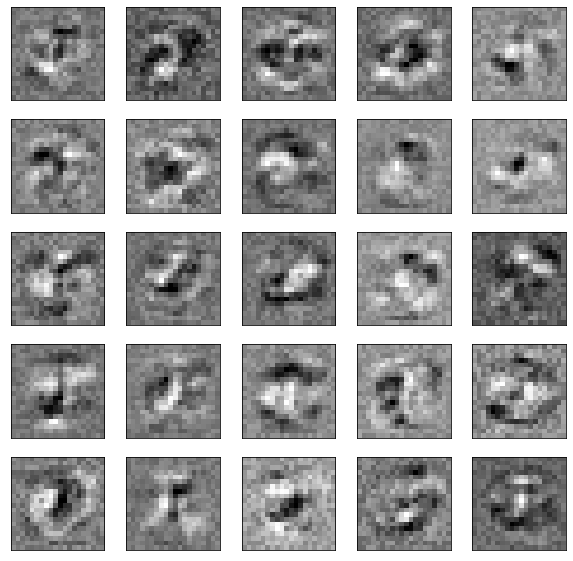

In [64]:
visualize_data(theta1[:, 1:])

### Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

In [68]:
def test_lambda(lambda_):
    initial_theta1 = rand_init_weights(input_layer_size, hidden_layer_size)
    initial_theta2 = rand_init_weights(hidden_layer_size, num_labels)
    initial_nn_params = np.concatenate([initial_theta1.ravel(), initial_theta2.ravel()])
    nn_params, costs = nn_gradient_descent(initial_nn_params,
                                           cost_func=lambda p: nn_cost_function(p, input_layer_size, hidden_layer_size,
                                                                                num_labels, x, y, lambda_=lambda_),
                                           alpha=0.5, num_iters=5000)

    print(f'Cost on trained network with lambda = {lambda_}: {costs[-1]}')

    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    p = predict(x, theta1, theta2)
    print(f'Prediction on training set wit lambda = {lambda_}: {np.mean(p == y) * 100}%')

    visualize_data(theta1[:, 1:])

Cost on trained network with regularization lambda = 1: 0.1716186839513631
Prediction on training set wit regularization lambda = 1: 98.46000000000001%


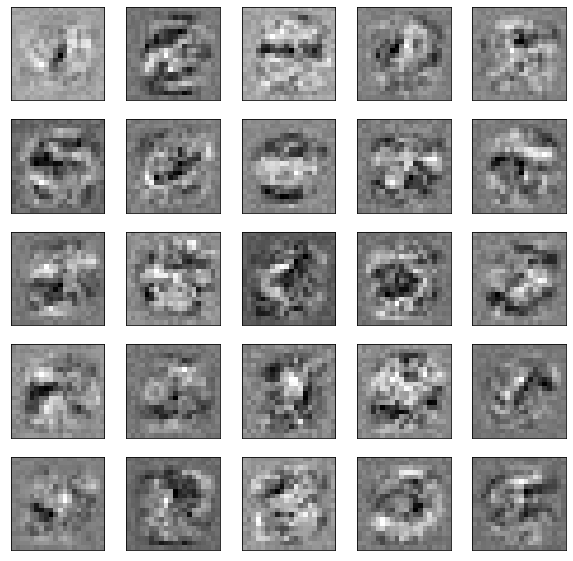

In [69]:
test_lambda(0)

Cost on trained network with regularization lambda = 1: 0.37190311904398177
Prediction on training set wit regularization lambda = 1: 97.72%


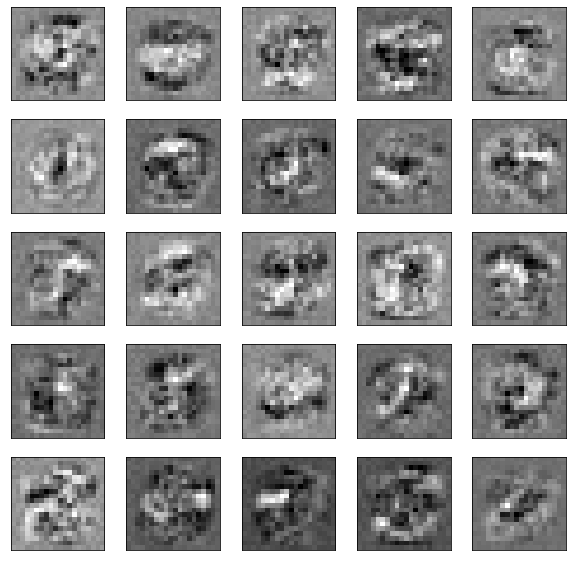

In [70]:
test_lambda(1)

Cost on trained network with regularization lambda = 1: 1.3447246106101214
Prediction on training set wit regularization lambda = 1: 92.06%


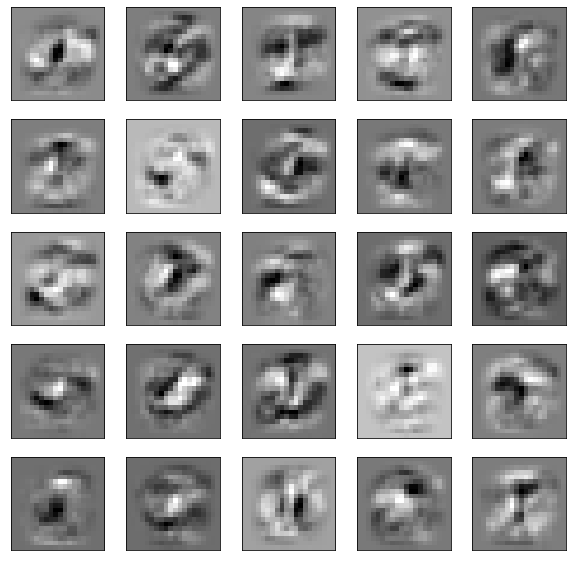

In [71]:
test_lambda(20)

По изображениям заметно что чем большее параметр регаляризации, тем более размытой становиться картинка.

## Вывод
В данной лабораточной работе мы разобрались с постоением нейроной сети с одним скрытым слоем, релизовали функцию стоимости и нахождение градиента. С помощью алгоритма градиентного спуска натренировали нейронную сеть с точностью придлиженной к 100%, визуализировали влияние релягулиризации на скрытый слой нейронной сети.